# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from tabulate import tabulate

# Importing Dataset

In [2]:
# Loading the data
fakenews_train_dataset = pd.read_csv("train.csv")
fakenews_train_dataset.head()

,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [3]:
# Understanding the data
fakenews_train_dataset.describe()

,id,tid1,tid2
count,256442.000000,256442.000000,256442.000000
mean,128220.500000,85063.728434,69712.542399
std,74028.573203,48402.199542,45481.347050
min,0.000000,0.000000,1.000000
25%,64110.250000,44052.000000,30619.000000
50%,128220.500000,85487.000000,63750.000000
75%,192330.750000,127504.000000,105255.750000
max,256441.000000,167563.000000,167557.000000


In [4]:
fakenews_train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256442 entries, 0 to 256441
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         256442 non-null  int64 
 1   tid1       256442 non-null  int64 
 2   tid2       256442 non-null  int64 
 3   title1_en  256442 non-null  object
 4   title2_en  256442 non-null  object
 5   label      256442 non-null  object
dtypes: int64(3), object(3)
memory usage: 11.7+ MB


unrelated    175598
agreed        74238
disagreed      6606
Name: label, dtype: int64

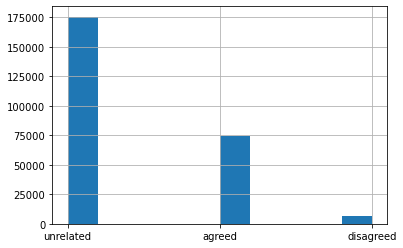

In [5]:
fakenews_train_dataset['label'].hist()
fakenews_train_dataset['label'].value_counts()

# Data Prepocessing

In [6]:
fakenews_train_dataset.isnull().sum()

id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
label        0
dtype: int64

In [7]:
cols = ['tid1', 'tid2']
fakenews_train_dataset = fakenews_train_dataset.drop(cols, axis=1)
fakenews_train_dataset.head()

,id,title1_en,title2_en,label
0,195611,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [8]:
stop_words = stopwords.words("english")
wordnet = WordNetLemmatizer()

def text_preproc(x):
  x = x.lower()
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  x = x.encode('ascii', 'ignore').decode()
  x = re.sub(r'https*\S+', ' ', x)
  x = re.sub(r'@\S+', ' ', x)
  x = re.sub(r'#\S+', ' ', x)
  x = re.sub(r'\'\w+', '', x)
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  x = re.sub(r'\w*\d+\w*', '', x)
  x = re.sub(r'\s{2,}', ' ', x)
  x = ' '.join([wordnet.lemmatize(word) for word in x.split()])
  return x


In [9]:
#Prepocessing the text columns in dataset
fakenews_train_dataset['title1_en'] = fakenews_train_dataset.title1_en.apply(text_preproc)
fakenews_train_dataset['title2_en'] = fakenews_train_dataset.title2_en.apply(text_preproc)

fakenews_train_dataset.head()

,id,title1_en,title2_en,label
0,195611,two new old age insurance benefit old people r...,police disprove bird nest congress person get ...,unrelated
1,191474,if come shenzhen sooner later son also come le...,shenzhen gdp outstrips hong kong shenzhen stat...,unrelated
2,25300,if come shenzhen sooner later son also come le...,gdp overtopped hong kong shenzhen clarified li...,unrelated
3,123757,if come shenzhen sooner later son also come le...,shenzhen gdp overtakes hong kong bureau statis...,unrelated
4,141761,if come shenzhen sooner later son also come le...,shenzhen gdp outpaces hong kong defending rumo...,unrelated


# Model Training

In [10]:
# Concatinating title 1 and title 2 and passing it as input variable.Making lable the output variable
X = fakenews_train_dataset['title1_en']+fakenews_train_dataset['title2_en']
y = fakenews_train_dataset['label']

# Spliting the data into 80 and 20
X_train,X_test,y_train,y_test= train_test_split(X,y, train_size=0.80,random_state=1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(205153,) (205153,) (51289,) (51289,)


In [11]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [12]:
model_nb = MultinomialNB()
model_nb.fit(train_vectors, y_train)

val_predictions_nb = model_nb.predict(test_vectors)

In [13]:
model_rf = RandomForestClassifier()
model_rf.fit(train_vectors, y_train)

val_predictions_rf = model_rf.predict(test_vectors)

In [14]:
model = DecisionTreeClassifier(random_state=42)
model.fit(train_vectors, y_train)

val_predictions_dt = model.predict(test_vectors)

In [15]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(train_vectors, y_train)

val_predictions_knn = model_knn.predict(test_vectors)

# Model Evaluation

In [16]:
val_accuracy_dt = accuracy_score(y_test, val_predictions_dt)
val_accuracy_rf= accuracy_score(y_test, val_predictions_rf)
val_accuracy_nb= accuracy_score(y_test, val_predictions_nb)
val_accuracy_knn= accuracy_score(y_test, val_predictions_knn)

In [17]:
data = [['Decision Tree Classifier Validation', val_accuracy_dt*100],
['Random Forest Classifier',val_accuracy_rf*100],
['Naive Bayes', val_accuracy_nb*100],
['KNN', val_accuracy_knn*100]]

df_accuracy = pd.DataFrame(data, columns=['Classifier Type', 'Accuracy(%)'])
df_accuracy = df_accuracy.sort_values('Accuracy(%)', ascending=False)

print (tabulate(data, headers=["Classifier Type", "Accuracy(%)"],tablefmt='fancy_grid',floatfmt=".2f"))

╒═════════════════════════════════════╤═══════════════╕
│ Classifier Type                     │   Accuracy(%) │
╞═════════════════════════════════════╪═══════════════╡
│ Decision Tree Classifier Validation │         77.01 │
├─────────────────────────────────────┼───────────────┤
│ Random Forest Classifier            │         85.08 │
├─────────────────────────────────────┼───────────────┤
│ Naive Bayes                         │         73.13 │
├─────────────────────────────────────┼───────────────┤
│ KNN                                 │         81.47 │
╘═════════════════════════════════════╧═══════════════╛


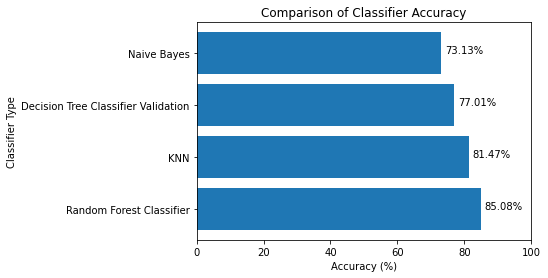

In [27]:
# create a horizontal bar chart
plt.barh(df_accuracy["Classifier Type"], df_accuracy["Accuracy(%)"])
plt.xlabel("Accuracy (%)")
plt.ylabel("Classifier Type")
plt.title("Comparison of Classifier Accuracy")
plt.xlim(0, 100)

for i, v in enumerate(df_accuracy["Accuracy(%)"]):
    plt.text(v + 1, i, "{:.2f}%".format(v))
    
plt.show()

In [19]:
val_classification_report_dt=classification_report(y_test, val_predictions_dt)
print("\n\nDecision Tree Classifier Classification Report:\n")
print(val_classification_report_dt)

val_classification_report_rf=classification_report(y_test, val_predictions_rf,zero_division=1)
print("\n\nRandom Forest Classifier Classification Report:\n")
print(val_classification_report_rf)

val_classification_report_nb=classification_report(y_test, val_predictions_nb)
print("\n\nNaive Bayes Classification Report:\n")
print(val_classification_report_nb)

val_classification_report_knn=classification_report(y_test, val_predictions_knn)
print("\n\nKNN Classification Report:\n")
print(val_classification_report_knn)



Decision Tree Classifier Classification Report:

              precision    recall  f1-score   support

      agreed       0.64      0.66      0.65     14916
   disagreed       0.42      0.37      0.40      1251
   unrelated       0.84      0.83      0.83     35122

    accuracy                           0.77     51289
   macro avg       0.63      0.62      0.63     51289
weighted avg       0.77      0.77      0.77     51289



Random Forest Classifier Classification Report:

              precision    recall  f1-score   support

      agreed       0.84      0.68      0.75     14916
   disagreed       0.82      0.26      0.39      1251
   unrelated       0.85      0.95      0.90     35122

    accuracy                           0.85     51289
   macro avg       0.84      0.63      0.68     51289
weighted avg       0.85      0.85      0.84     51289



Naive Bayes Classification Report:

              precision    recall  f1-score   support

      agreed       0.87      0.19      0.31

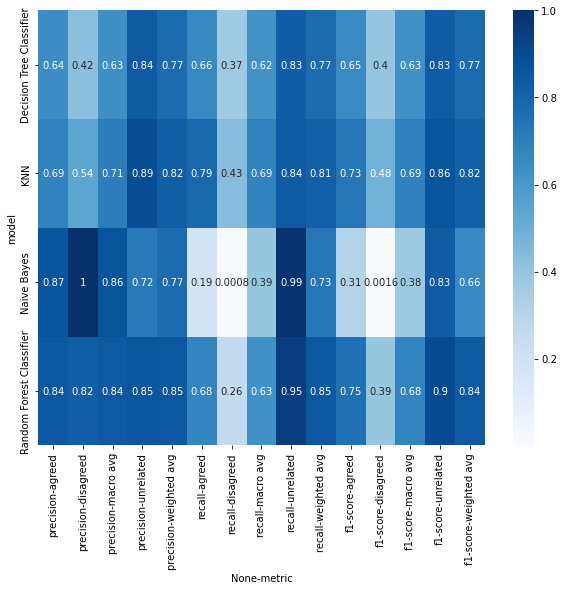

In [20]:
# create a dictionary of models and their predictions
models = {
    'Decision Tree Classifier': val_predictions_dt,
    'Random Forest Classifier': val_predictions_rf,
    'Naive Bayes': val_predictions_nb,
    'KNN': val_predictions_knn
}

# create an empty dictionary to store the classification reports
reports = {}

# loop through each model and calculate the classification report
for name, preds in models.items():
    report = classification_report(y_test, preds, output_dict=True)
    reports[name] = report
    
# convert the reports dictionary to a dataframe
df = pd.DataFrame.from_dict({(i,j): reports[i][j] 
                             for i in reports.keys() 
                             for j in reports[i].keys() 
                             if not isinstance(reports[i][j], float)},
                            orient='index')

# extract the precision, recall, and f1-score columns
df = df[['precision', 'recall', 'f1-score']]

# reshape the dataframe for plotting
df = df.reset_index()
df = df.rename(columns={'level_0': 'model', 'level_1': 'metric'})
df = df.pivot(index='model', columns='metric')

# create the heatmap with larger font size for annotations
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='Blues', annot_kws={"fontsize":10})
plt.show()

# Model Predication

In [21]:
# load the test data
test_df = pd.read_csv('test.csv')
test_df['title1_en'] = test_df.title1_en.apply(text_preproc)
test_df['title2_en'] = test_df.title2_en.apply(text_preproc)
test_df.head()

,id,tid1,tid2,title1_en,title2_en
0,256442,100672,100673,great coat brother zhu zhu wen mandarin love s...,lin xinsheng birth hard milking huo jianhua se...
1,256443,162269,162270,nasa reveals fact ufo wreckage found moon,ufo found yuancun jiaocheng county shanxi shoc...
2,256444,157826,157854,hollow tomato loaded hormone,li chenfan bingbing home photo netizen called ...
3,256445,109579,74076,ange pavilion geoshui accurate matrimony match...,master one eight character presumption marriag...
4,256446,15068,15085,year old bus bus blow year old child rumor rum...,joe johnson disgruntled timing order myth


In [22]:
test_texts = test_df['title1_en'] + test_df['title2_en']
test_vectors = vectorizer.transform(test_texts)

# make predictions on the test set
test_predictions = model_rf.predict(test_vectors)

# save the predictions to a file in the required format
submission_df = pd.DataFrame({'id': test_df['id'], 'label': test_predictions})
submission_df.to_csv('submission.csv', index=False)

unrelated    48340
agreed       15267
disagreed      503
Name: label, dtype: int64

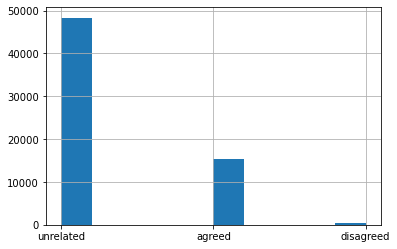

In [23]:
submission_df['label'].hist()
submission_df['label'].value_counts()